In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#https://python.langchain.com/docs/tutorials/rag/

In [3]:
# Load documents from directory
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("pinnacle_capstone_data")
docs = loader.load()

In [4]:
len(docs)

95

In [5]:
# Experiment with embedding models
from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings
import os, yaml

with open('chatgpt_api_credentials.yml') as f:
    credentials = yaml.safe_load(f)

os.environ['OPENAI_API_KEY']=credentials['openai_key']

openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

llama_embed_model = OllamaEmbeddings(
    model="llama3.2"
)

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
len(all_splits)

393

In [8]:
# https://python.langchain.com/docs/integrations/vectorstores/chroma/
from langchain_chroma import Chroma

# Two vecto stores for two embedding models -> different collections to avoid dimensionality error 
# Open ai and llama embeddings have different lengths
vector_store1 = Chroma(collection_name="openai_collection_1", embedding_function=openai_embed_model,
                      persist_directory="./chroma_db3")

#vectordb = Chroma.from_documents(documents=splits, embedding=openai_embed_model)
#vectordb = Chroma.from_documents(documents=splits, embedding=llama_embed_model)

In [9]:
vector_store2 = Chroma(
    collection_name="llama_collection_1", 
    embedding_function=llama_embed_model,
    persist_directory="./chroma_db4"  # Specify a directory to store the data
)

In [13]:
# add documents to both vector stores
document_ids_1 = vector_store1.add_documents(documents=all_splits[:])
document_ids_2 = vector_store2.add_documents(documents=all_splits[:])

In [14]:
retriever = vector_store1.as_retriever(search_type="mmr")

In [15]:
docs = retriever.invoke("what is attention")

In [16]:
len(docs)

4

In [17]:
from typing import List

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

# Output parser will split the LLM result into a list of queries
class LineList(BaseModel):
    # "lines" is the key (attribute name) of the parsed output
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


#output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate two 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)
llm = ChatOpenAI(temperature=0)

# Chain
llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT)

# Run
multi_query_retriever = MultiQueryRetriever(
    retriever=vector_store1.as_retriever(), llm_chain=llm_chain #parser_key="lines"
)  # "lines" is the key (attribute name) of the parsed output

/var/folders/81/7z5hxt0d3cbd95svhrc31swh0000gn/T/ipykernel_19882/868067471.py:39: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT)


In [18]:
# Results
unique_docs = multi_query_retriever.invoke(input="What is attention")
len(unique_docs)

72

In [19]:
unique_docs[0]

Document(id='9366f1f0-3ce5-401a-944b-ec7d02607ab4', metadata={'author': '', 'creationdate': '2024-04-10T21:11:43+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'page': 12, 'page_label': '13', 'producer': 'pdfTeX-1.40.25', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'source': 'pinnacle_capstone_data/attention_paper.pdf', 'subject': '', 'title': '', 'total_pages': 15, 'trapped': '/False'}, page_content='Attention Visualizations\nInput-Input Layer5\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n

In [20]:
question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vector_store2.as_retriever(), llm=llm
)
unique_docs = retriever_from_llm.invoke(question)

In [21]:
len(unique_docs)

6

In [22]:
# This text splitter is used to create the parent documents
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

vectorstore = Chroma(
    collection_name="full_documents", embedding_function=OpenAIEmbeddings()
)

parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
store = InMemoryStore()
p_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [23]:
p_retriever.add_documents(docs, ids=None)

In [24]:
retrieved_docs = p_retriever.invoke("what is attention")

In [25]:
len(retrieved_docs)

2

In [26]:
for i in range(len(retrieved_docs)):
    print(retrieved_docs[i].page_content)
    print()
    print('////////')

3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3

////////
in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes
it more difficult to learn dependencies between distant positions [ 12]. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as
described in section 3.2.
Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent 

In [27]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [28]:
def retrieve(state: State):
    #retrieved_docs = vector_store.similarity_search(state["question"])
    retrieved_docs = multi_query_retriever.invoke(input=state['question'])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [29]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [30]:
response = graph.invoke({"question": "What is attention?"})
print(response["answer"])

Attention is a mechanism in machine learning models that allows them to focus on specific parts of input data during processing. It helps the model to prioritize certain information and make more informed decisions based on the highlighted features. In the context provided, attention is visualized as heads attending to distant dependencies in the input data, such as completing phrases or identifying key words.


In [31]:
# FOR AGENTIC RAG
import os, yaml
with open('tavily_api_credentials.yml') as f:
    credentials = yaml.safe_load(f)
os.environ['TAVILY_API_KEY']=credentials['TAVILY_API_KEY']

In [32]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# 1.QUERY RETRIEVAL GRADER
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
# LLM for grading
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}
                     User question:
                     {question}
                  """),
    ]
)
# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

# 2.QUESTION REWRITER

SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}
                     Formulate an improved question.
                  """,
        ),
    ]
)
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       chatgpt
                        |
                     StrOutputParser())



# QA RAG CHAIN
prompt1 = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.
            Question:
            {question}
            Context:
            {context}
            Answer:
         """
prompt_template1 = ChatPromptTemplate.from_template(prompt1)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def format_history(history):
    return "\n".join(f"User: {turn['question']}\nAssistant: {turn['answer']}" for turn in history)


# QA RAG CHAIN
prompt2 = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context and conversation history to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.
            Conversation History:
            {history}
            Question:
            {question}
            Context:
            {context}
            Answer:
         """
prompt_template2 = ChatPromptTemplate.from_template(prompt2)

    
# create QA RAG chain with conversation history
# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template1
      |
    chatgpt
      |
    StrOutputParser()
)

qa_rag_chain_with_history = (
    {
        "context": (itemgetter('context') | RunnableLambda(format_docs)),
        "question": itemgetter('question'),
        "history": itemgetter('history') | RunnableLambda(format_history)
    }
    | prompt_template2
    | chatgpt
    | StrOutputParser()
)

In [45]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x114f008d0>, search_type='mmr', search_kwargs={})

In [78]:
# BUILDING THE RAG AGENT
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]
    history: List[dict]

def retrieve_v2(state:GraphState):
    question = state['question']
    retrieved_docs = p_retriever.invoke(question)
    return {"documents": retrieved_docs, "question": question}

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)



def grade_documents(state:GraphState):
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    web_search_needed = 'No'
    if documents:
        for d in documents:
            score = doc_grader.invoke({'question':question, 'document': d.page_content})
            grade = score.binary_score
            if grade == 'yes':
                filtered_docs.append(d)
            else:
                web_search_needed = 'Yes'
    else:
        web_search_needed = 'Yes'
        
    return {"documents": filtered_docs, "question": question, 
            "web_search_needed": web_search_needed}
        
def rewrite_query(state:GraphState):
    question = state["question"]
    documents = state["documents"]
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state:GraphState):
    question = state['question']
    documents = state['documents']
    
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

def generate_answer(state:GraphState):
    question = state['question']
    documents = state['documents']
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, 
            "generation": generation}

def generate_answer_v2(state:GraphState):
    question = state['question']
    documents = state['documents']
    history = state['history']

    response = qa_rag_chain_with_history.invoke({"question": question, "context": documents, "history": history})
    history.append({"question": question, "answer": response})

    return {"documents": documents, "question": question, "generation": response, "history": history}

def should_generate(state:GraphState):
    web_search_needed = state['web_search_needed']
    
    if web_search_needed =='Yes':
        return 'web_search'
        #return 'rewrite_query'
    return 'generate_answer_v2'

In [79]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)
agentic_rag.add_node("retrieve_v2", retrieve_v2)
agentic_rag.add_node("grade_documents", grade_documents)
#agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer_v2", generate_answer_v2)

agentic_rag.set_entry_point("retrieve_v2")
agentic_rag.add_edge("retrieve_v2", "grade_documents")

agentic_rag.add_conditional_edges(
    "grade_documents",
    should_generate,
    {"web_search": "web_search", "generate_answer_v2": "generate_answer_v2"},
)
#agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer_v2")
agentic_rag.add_edge("generate_answer_v2", END)
agentic_rag_compiled = agentic_rag.compile()

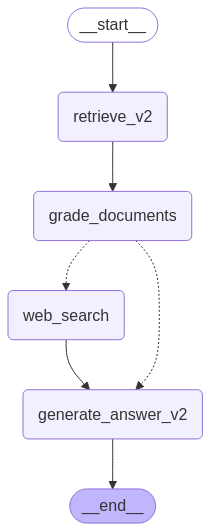

In [80]:
from IPython.display import Image, display, Markdown
display(Image(agentic_rag_compiled.get_graph().draw_mermaid_png()))

In [86]:
query = "what is gemini?"
#response = agentic_rag_compiled.invoke({"question": query})

# First invocation
query1 = "What is gemini?"
state1 = agentic_rag_compiled.invoke({
    "question": query1,
    "documents": [],
    "web_search_needed": "No",
    "history": []  # Initial empty history
})
print(state1['generation'])

Gemini is Google's most capable AI model yet, designed to accelerate the development of large-scale generative AI models and help developers and enterprise customers train them faster. Gemini provides direct access to Google AI, offering assistance with writing, planning, learning, and more. It is equipped with comprehensive safety evaluations, including for bias and toxicity, making it one of the most advanced AI models from Google to date. Additionally, Bard Advanced, a cutting-edge AI experience, will be launched soon, providing access to the best models and capabilities starting with Gemini Ultra.


In [87]:
# Create a new state, but keep the history from state1
query2='Who-are-its-competitors'
state2 = {
    "question": query2,
    "documents": [],  # Reset documents
    "web_search_needed": "No",  # Reset web_search_needed
    "history": state1["history"]  # Keep the history
}
state2 = agentic_rag_compiled.invoke(state2)
print(state2['generation'])

Some of the competitors to Gemini in the AI model space include OpenAI's GPT-3, Microsoft's Turing-NLG, and Facebook's RoBERTa. These models are also large-scale generative AI models that offer advanced capabilities for various tasks such as natural language processing, text generation, and more. Each of these competitors has its strengths and weaknesses, and developers and enterprise customers may choose one over the other based on their specific requirements and use cases. Conducting a thorough competitive analysis can help in understanding how Gemini stacks up against its competitors in terms of features, performance, safety evaluations, and overall capabilities.


In [ ]:
# Create a new state, but keep the history from state1
query2='Who-are-its-competitors'
state2 = {
    "question": query2,
    "documents": [],  # Reset documents
    "web_search_needed": "No",  # Reset web_search_needed
    "history": state1["history"]  # Keep the history
}
state2 = agentic_rag_compiled.invoke(state2)
print(state2['generation'])

In [85]:
state2 = agentic_rag_compiled.invoke(state1)
query2 = "Summarize the key points.giveonewo"
print(state2['generation'])

Gemini is Google's most capable AI model yet, designed to accelerate the development of large-scale generative AI models. It allows developers and enterprise customers to train models faster, bringing new products and capabilities to customers sooner. Gemini has comprehensive safety evaluations, including for bias and toxicity, making it one of the safest AI models from Google to date. Users have direct access to Google AI for assistance with writing, planning, learning, and more. Gemini is part of Google's efforts to provide cutting-edge AI experiences to users through platforms like Bard Advanced.


In [88]:
response

{'question': 'what is gemini?',
 'generation': "Gemini is Google's most capable AI model yet, designed to accelerate the development of large-scale generative AI models and help developers and enterprise customers train them faster. Gemini provides direct access to Google AI for tasks such as writing, planning, and learning. It is equipped with comprehensive safety evaluations, including for bias and toxicity, making it one of the most advanced AI models from Google to date. Additionally, Gemini will be launching Bard Advanced, a cutting-edge AI experience that offers access to the best models and capabilities, starting with Gemini Ultra.",
 'web_search_needed': 'Yes',
 'documents': [Document(metadata={}, page_content='Introducing Gemini: Google’s most capable AI model yet This next generation TPU will accelerate Gemini’s development and help developers and enterprise customers train large-scale generative AI models faster, allowing new products and capabilities to reach customers soon

In [91]:
count = 0
state1 = None

while True:
    query = input("\033[94mAsk a question about your documents or (STOP) to stop the conversation:\033[0m ")  # Blue prompt
    if query.upper() == 'STOP':
        break

    if count == 0:
        state1 = agentic_rag_compiled.invoke({
            "question": query,
            "documents": [],
            "web_search_needed": "No",
            "history": []
        })
    else:
        temp_state = {
            "question": query,
            "documents": [],
            "web_search_needed": "No",
            "history": state1["history"]
        }
        state1 = agentic_rag_compiled.invoke(temp_state)
        

    print("\n" + state1['generation'])  # Black response with newline
    count += 1

Ask a question about your documents or (STOP) to stop the conversation: What-is-claude

Claude AI is a generative artificial intelligence chatbot and a family of large language models developed by the research firm Anthropic. Claude adheres to Anthropic's Constitutional AI philosophy, which is a code of ethical norms that differentiates Claude from other AI models like ChatGPT and Google's Gemini. Anthropic offers free access to their best Claude model through their chat interface at claude.ai, which is still in open beta testing as of October 2023. The free tier of Claude AI provides users with access to Anthropic's latest and most capable model, Claude 2. Developers can access Claude AI models through the Anthropic API or Amazon Bedrock. Claude is known for its 100K token input limit, transparent approach to AI safety with a "constitution," and the free access to the best Claude model developed so far, Claude-2.
Ask a question about your documents or (STOP) to stop the conversation: 

In [64]:
response['generation']

"Gemini is Google's most capable AI model yet, designed to accelerate the development of large-scale generative AI models and help developers and enterprise customers train them faster. Gemini provides direct access to Google AI for tasks such as writing, planning, and learning. It is equipped with comprehensive safety evaluations, including for bias and toxicity, making it one of the most advanced AI models from Google to date. Additionally, Gemini will be launching Bard Advanced, a cutting-edge AI experience that offers access to the best models and capabilities, starting with Gemini Ultra."

In [65]:
query = "who-created-it?"
response = agentic_rag_compiled.invoke({"question": query})

In [66]:
response

{'question': 'who-created-it?',
 'generation': 'The study series for beginning readers ages 4-7 was created by the director, screenwriters, and other individuals involved in the production of the series. The specific creator or creators are not mentioned in the provided context.',
 'web_search_needed': 'Yes',
 'documents': [Document(metadata={}, page_content='An all-new study series for beginning readers ages 4-7. Each book is designed to help children build a familiarity with and love for God\'s Word at an early age.\n\nMaria Sciullo of The Pittsburgh Post-Gazette wrote: "Dylan Grazer and Lillis are standouts among a pretty good bunch of child actors."[450] Tasha Robinson of The Verge praised all seven of the central children, saying each are "well-cast and give strong performances" in the film.[451] She also said Ray Taylor\'s portrayal of Ben Hanscom is "surprisingly tender and nuanced", Skarsgård seemed "like a real threat" as Pennywise, and that Lillis is close to "heartbreaking" 